In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization
from keras.models import Model
from keras.datasets import cifar10
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import CSVLogger
from keras.optimizers import Adam, RMSprop

import numpy as np
import matplotlib.pyplot as plt
import argparse

Using TensorFlow backend.
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Conda\envs\Tensorflow-GPU\lib\site-packages\tensorflow\python\fra

In [2]:
# dimension of the latent space (min 2)
latent_dim = 512

# CIFAR dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# choose one of them
my_class = 7

# parameters, we will use it later
# 32
image_size = x_train.shape[1]
# 32x32x3
input_shape = (image_size, image_size, 3)

# Normalization of pixel values (to [0-1] range)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

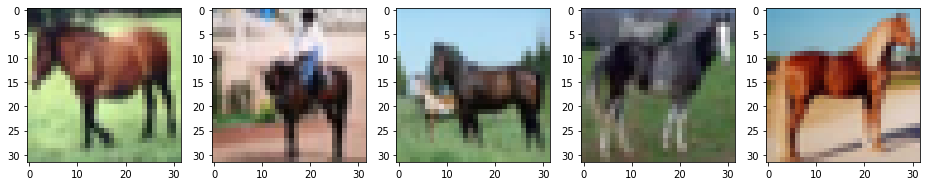

In [4]:
# select images of one class
number_of_images = 5000
n = 0
i = 0
x_in = np.zeros((number_of_images,image_size,image_size,3))

for y in y_train:
    if (y == my_class and n != number_of_images-1):
        x_in[n]=(x_train[i])
        n += 1
    i += 1 
    
# and show some of them
f, axarr = plt.subplots(1, 5)
f.set_size_inches(16, 6)
for i in range(5):
    img = x_in[i]
    axarr[i].imshow(img)
plt.show()

# AAE MODEL

## ENCODER

In [5]:
# reparameterization trick
# z = mean + sqrt(var)*eps
# where only eps is random, we can backprop on the other parameters
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [6]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = Conv2D(filters=64, kernel_size=2, activation='relu', strides=2, padding='same')(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(x)     
x = Conv2D(filters=256, kernel_size=3, activation='relu', strides=2, padding='same')(x)   

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(latent_dim*2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     8256        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 4, 4, 128)    73856       conv2d_2[0][0]                   
_____________________________________

## DECODER

In [7]:
# input = z latent space
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=256, kernel_size=5, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = Conv2DTranspose(filters=128, kernel_size=5, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = Conv2DTranspose(filters=32, kernel_size=2, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
outputs = Conv2DTranspose(filters=3, kernel_size=2, activation='sigmoid', padding='same', name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         1638656   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 128)         819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 128)         512       
__________

## DISCRIMINATOR

In [8]:
disc_inputs = Input(shape=(latent_dim,))
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(disc_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2D(filters=64, kernel_size=2, activation='relu', strides=2, padding='same')(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)     
disc_out = Dense(1, activation='sigmoid')(x)

# instantiate discriminator model
discriminator = Model(disc_inputs, disc_out, name='discriminator')
discriminator.summary()

# instantiate encoder_discriminator model
encoder_discriminator = Model(inputs, discriminator(encoder(inputs)[2]))

# compile the trainable discriminator
discriminator.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# compile the encoder discriminator model, where only the encoder is trainable
for layer in discriminator.layers:
    layer.trainable = False
encoder_discriminator.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
reshape_2 (Reshape)          (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 64)          65600     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 32)          18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total para

## AAE

In [9]:
# out = D(E(x))
# where E(x)=z
outputs = decoder(encoder(inputs)[2])
aae = Model(inputs, outputs, name='aae')

In [10]:
# now AAE loss is only = xent_loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= image_size * image_size
aae_loss = K.mean(reconstruction_loss)

In [11]:
# compile AAE with loss
aae.add_loss(aae_loss)
aae.compile(optimizer='adam')
aae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 512), (None, 512) 2477376   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         3067619   
Total params: 5,544,995
Trainable params: 5,544,035
Non-trainable params: 960
_________________________________________________________________


# TRAIN

In [12]:
def train( x_train, batch_size=256, epochs=400):
    # logger
    csv_logger = CSVLogger('AAElog.csv', append=True, separator=';')
    trainG, trainD = True, True
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        #---------------Train Discriminator -------------
        # on half a batch real and half a batch fake data
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        imgs = x_train[idx]
        latent_fake = encoder.predict(imgs)[2]
        latent_real = np.random.normal(size=(half_batch, latent_dim))
        valid = np.ones((half_batch, 1))
        fake = np.zeros((half_batch, 1))
        if (trainD):
            d_loss_real = discriminator.train_on_batch(latent_real, valid)
            d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #---------------Train Generator -------------
        # on one batch fake data
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        valid_y = np.ones((batch_size, 1))
        if (trainG):
            g_logg_similarity = encoder_discriminator.train_on_batch(imgs, valid_y)

        # with this the adversarial part can learn the latent distribution better, but the generated images are better without it
        # if one model of the adversarial part is too strong, then we dont let it train
        #if (d_loss[1]*0.8 > g_logg_similarity[1]):
            #trainG = True
            #trainD = False
        #elif (g_logg_similarity[1]*0.8 > d_loss[1]):
            #trainG = False
            #trainD = True
        #else:
            #trainG = True
            #trainD = True

        #---------------Train Autoencoder -------------
        g_loss_reconstruction = aae.fit(imgs, validation_data=(imgs, None), verbose=0, callbacks=[csv_logger])

        #---------------Plot the progress---------------
        print ("%d [D loss: %f, acc: %.2f%%] [G acc: %f, val_loss: %f]" % (epoch, d_loss[0], 100*d_loss[1],
               g_logg_similarity[1], g_loss_reconstruction.history['val_loss'][0]))

In [13]:
train( x_in)
aae.save_weights('aae_cnn_cifar.h5')

Instructions for updating:
Use tf.cast instead.


C:\Conda\envs\Tensorflow-GPU\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.064247, acc: 7.42%] [G acc: 0.929688, val_loss: 1131.651825]
1 [D loss: 4.380540, acc: 47.27%] [G acc: 0.000000, val_loss: 837.138451]
2 [D loss: 0.907907, acc: 41.80%] [G acc: 0.000000, val_loss: 876.138542]
3 [D loss: 0.406073, acc: 95.70%] [G acc: 0.003906, val_loss: 805.618698]
4 [D loss: 0.332831, acc: 97.66%] [G acc: 0.007812, val_loss: 687.416412]
5 [D loss: 0.478275, acc: 99.61%] [G acc: 0.007812, val_loss: 717.103645]
6 [D loss: 0.351487, acc: 99.22%] [G acc: 0.003906, val_loss: 680.022385]
7 [D loss: 0.452456, acc: 97.27%] [G acc: 0.003906, val_loss: 783.263802]
8 [D loss: 0.291947, acc: 99.22%] [G acc: 0.015625, val_loss: 753.498383]
9 [D loss: 0.263377, acc: 99.61%] [G acc: 0.011719, val_loss: 723.185242]
10 [D loss: 0.255574, acc: 98.83%] [G acc: 0.000000, val_loss: 663.141060]
11 [D loss: 0.301629, acc: 97.66%] [G acc: 0.023438, val_loss: 681.959938]
12 [D loss: 0.217921, acc: 98.44%] [G acc: 0.027344, val_loss: 698.851097]
13 [D loss: 0.147847, acc: 100.00%]

109 [D loss: 0.016747, acc: 99.22%] [G acc: 0.000000, val_loss: 622.655739]
110 [D loss: 0.006162, acc: 100.00%] [G acc: 0.003906, val_loss: 628.288254]
111 [D loss: 0.070376, acc: 97.66%] [G acc: 0.000000, val_loss: 619.715530]
112 [D loss: 0.021320, acc: 99.22%] [G acc: 0.000000, val_loss: 624.614670]
113 [D loss: 0.016535, acc: 99.61%] [G acc: 0.003906, val_loss: 630.908409]
114 [D loss: 0.016383, acc: 99.61%] [G acc: 0.000000, val_loss: 638.976349]
115 [D loss: 0.010758, acc: 100.00%] [G acc: 0.000000, val_loss: 614.786102]
116 [D loss: 0.035583, acc: 98.83%] [G acc: 0.000000, val_loss: 624.121185]
117 [D loss: 0.021894, acc: 99.61%] [G acc: 0.007812, val_loss: 618.708031]
118 [D loss: 0.006862, acc: 100.00%] [G acc: 0.003906, val_loss: 620.688782]
119 [D loss: 0.024472, acc: 99.22%] [G acc: 0.000000, val_loss: 609.184578]
120 [D loss: 0.031099, acc: 99.61%] [G acc: 0.003906, val_loss: 626.161606]
121 [D loss: 0.012647, acc: 99.61%] [G acc: 0.000000, val_loss: 617.490135]
122 [D lo

217 [D loss: 0.016481, acc: 99.22%] [G acc: 0.000000, val_loss: 615.098373]
218 [D loss: 0.006934, acc: 100.00%] [G acc: 0.011719, val_loss: 605.651756]
219 [D loss: 0.380684, acc: 90.23%] [G acc: 0.000000, val_loss: 605.314774]
220 [D loss: 0.103862, acc: 96.48%] [G acc: 0.000000, val_loss: 610.820717]
221 [D loss: 0.014709, acc: 99.22%] [G acc: 0.000000, val_loss: 607.572754]
222 [D loss: 0.015930, acc: 99.22%] [G acc: 0.003906, val_loss: 615.485588]
223 [D loss: 0.050115, acc: 98.44%] [G acc: 0.003906, val_loss: 606.621368]
224 [D loss: 0.042382, acc: 98.83%] [G acc: 0.007812, val_loss: 599.937927]
225 [D loss: 0.460125, acc: 86.72%] [G acc: 0.000000, val_loss: 606.479645]
226 [D loss: 0.242456, acc: 92.58%] [G acc: 0.000000, val_loss: 611.289818]
227 [D loss: 0.038442, acc: 98.83%] [G acc: 0.000000, val_loss: 604.194267]
228 [D loss: 0.009997, acc: 99.61%] [G acc: 0.000000, val_loss: 601.692390]
229 [D loss: 0.007756, acc: 100.00%] [G acc: 0.000000, val_loss: 604.000381]
230 [D los

325 [D loss: 0.164266, acc: 94.92%] [G acc: 0.000000, val_loss: 603.795204]
326 [D loss: 0.065198, acc: 98.83%] [G acc: 0.000000, val_loss: 606.641289]
327 [D loss: 0.013414, acc: 99.22%] [G acc: 0.003906, val_loss: 596.355789]
328 [D loss: 0.002994, acc: 100.00%] [G acc: 0.000000, val_loss: 601.415787]
329 [D loss: 0.003182, acc: 100.00%] [G acc: 0.003906, val_loss: 593.204117]
330 [D loss: 0.163881, acc: 95.31%] [G acc: 0.000000, val_loss: 604.820007]
331 [D loss: 0.043073, acc: 98.83%] [G acc: 0.000000, val_loss: 600.388939]
332 [D loss: 0.007951, acc: 100.00%] [G acc: 0.000000, val_loss: 605.229607]
333 [D loss: 0.016859, acc: 99.22%] [G acc: 0.000000, val_loss: 601.669144]
334 [D loss: 0.048790, acc: 98.05%] [G acc: 0.000000, val_loss: 604.831596]
335 [D loss: 0.053531, acc: 98.44%] [G acc: 0.000000, val_loss: 601.802238]
336 [D loss: 0.026269, acc: 99.22%] [G acc: 0.003906, val_loss: 605.032372]
337 [D loss: 0.199958, acc: 93.75%] [G acc: 0.000000, val_loss: 598.417656]
338 [D lo

# PLOT

In [18]:
def plot_results(encoder, decoder, x_test, y_test, batch_size=128, model_name="aae_cifar"):
    
    # display a nxn 2D manifold of images
    n = 10
    img_size = 32
    figure = np.zeros((img_size * n, img_size * n,3))
    # linearly spaced coordinates corresponding to the 2D plot
    grid_x = np.linspace(-1, 1, n)
    grid_y = np.linspace(-1, 1, n)[::-1]

  # display a 2D plot of the image classes in the first 2 dimensions of the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(n, n))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

  # display the generated images along the first 2 dimensions of the latent space
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.random.normal(0.0, 1.0, (1,latent_dim))
            # the first two dim is given
            z_sample[0,0]=xi
            z_sample[0,1]=yi
            # generate an image from the latent representation
            x_decoded = decoder.predict(z_sample)
            img = x_decoded[0].reshape(img_size, img_size, 3)
            figure[i * img_size: (i + 1) * img_size,
                   j * img_size: (j + 1) * img_size,] = img

    plt.figure(figsize=(20, 20))
    start_range = img_size // 2
    end_range = n * img_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

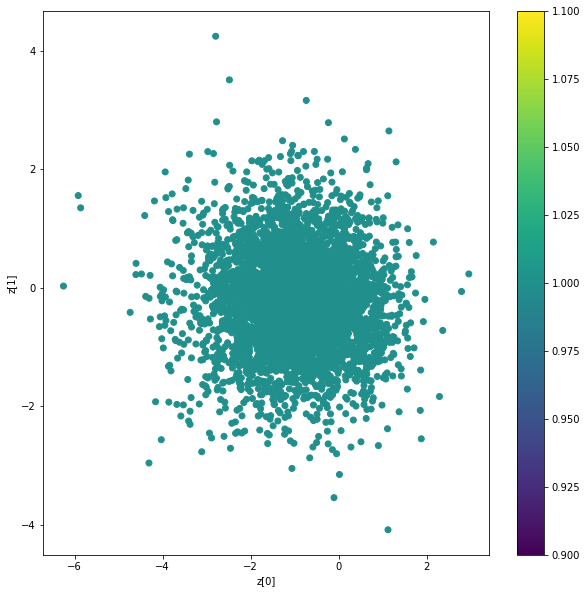

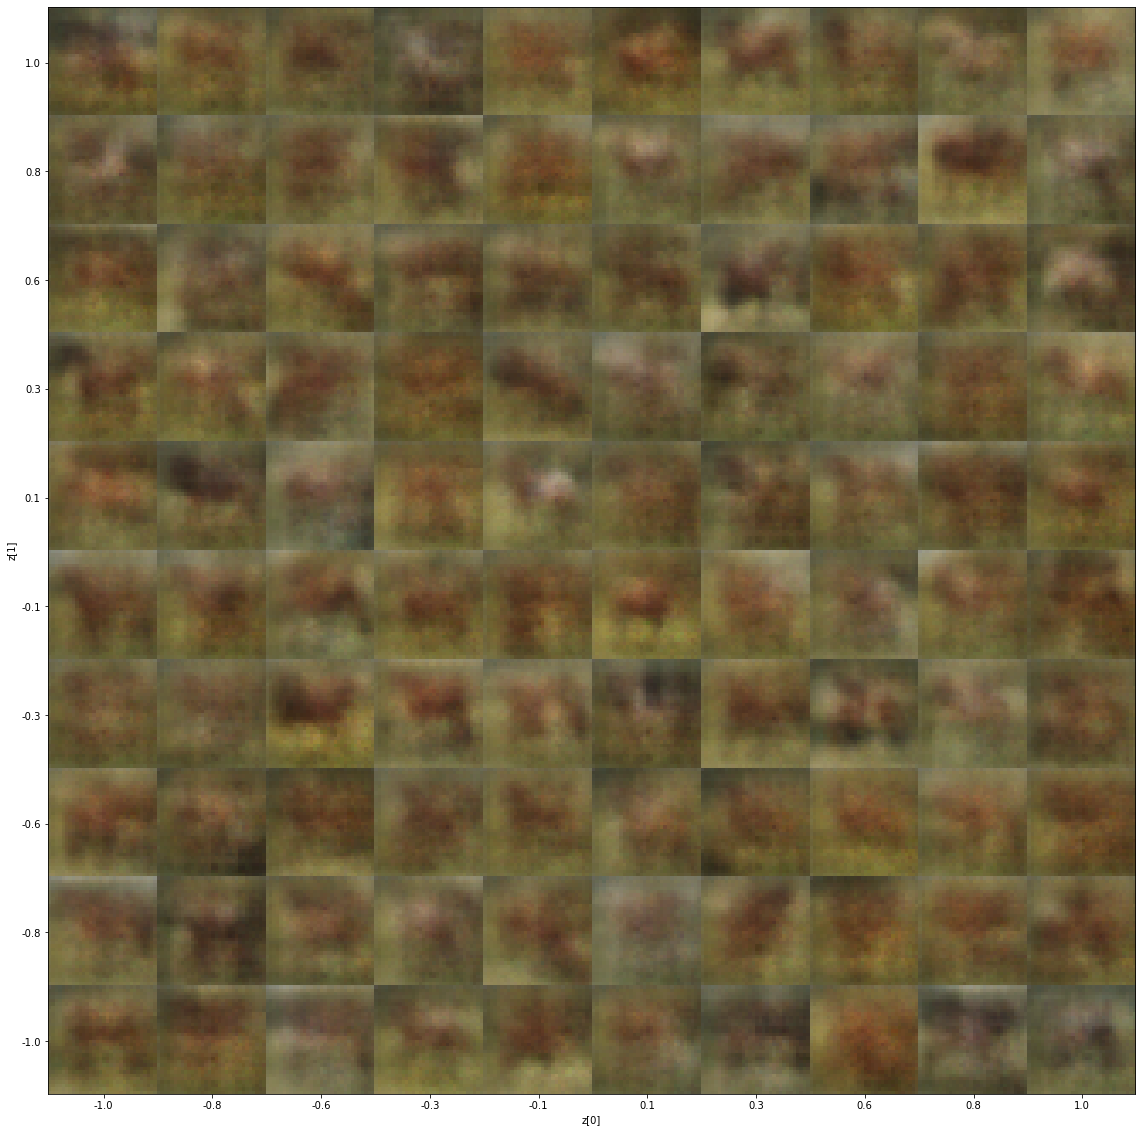

In [19]:
# now we have only one class
plot_results(encoder, decoder, x_in, np.ones((x_in.shape[0])), batch_size=128, model_name="aae_cnn")